# CG-sense

(3372, 2)
212.4907335660468 -207.50604111035412


SenseRecon: 100%|██████████| 50/50 [00:00<00:00, 61.10it/s, resid=5.26E-04]


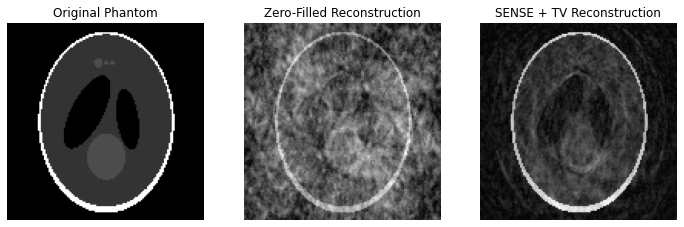

In [3]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
img_shape = (N, N)
phantom = sp.shepp_logan(img_shape)

# **2. マルチコイル感度マップの生成 (birdcage model, 4 coils)**
num_coils = 4
mps = mri.birdcage_maps((num_coils, *img_shape))  # (4, 128, 128)

# **3. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3, N=N, f_sampling=1.0, R=3, ninterleaves=1, alpha=1.0, gm=0.04, sm=150
)
print(coords.shape)  # (N, 2)
print(coords.max(), coords.min())  # 0.5, -0.5

# **4. Non-Cartesian k-space の計算**
nufft_ops = [sp.linop.NUFFT(img_shape, coord=coords) for _ in range(num_coils)]
nufft_adjs = [op.H for op in nufft_ops]
ksp = np.array([nufft_ops[i](phantom * mps[i]) for i in range(num_coils)])

# **5. Zero-Filled Reconstruction**
img_zero_filled = np.sum([nufft_adjs[i](ksp[i]) for i in range(num_coils)], axis=0)

# **6. SENSE + TV 再構成**
lamda = 0.01  # TV 正則化の強さ
max_iter = 50  # 反復回数

sense_app = mri.app.SenseRecon(
    ksp, mps, coord=coords, lamda=lamda, max_iter=max_iter, solver='ConjugateGradient'
)
reconstructed_img = sense_app.run()

# **7. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")  # 修正済み
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(np.abs(reconstructed_img), cmap="gray")
axs[2].set_title("SENSE + TV Reconstruction")
axs[2].axis("off")

plt.show()
